In [20]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np

from cosmo_compression.data import data
from cosmo_compression.model import represent

device = "cuda" if torch.cuda.is_available() else "cpu"
model_ckpt = '~/latent_ablation_workshop_outc/no_hierarchical_64/step=step=17700-val_loss=0.257.ckpt'   # ← change to your .ckpt
dataset_path = '/monolith/global_data/astro_compression/CAMELS/'

In [21]:
# Parameters
type_map = "Mcdm"
res = 256
mean = data.NORM_DICT[type_map][res]["mean"]
std = data.NORM_DICT[type_map][res]["std"]

# Load dataset and model
dataset = data.CAMELS(
    root=dataset_path,
    map_type=type_map,
    dataset="1P",
    parameters=["Omega_m", "sigma_8"],
)
model = represent.CosmoFlow.load_from_checkpoint(model_ckpt).to(device)
model.eval()


CosmoFlow(
  (encoder): ResNetEncoder(
    (resnet_list): ModuleList(
      (0): ResNet(
        (in_layer): Sequential(
          (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=circular)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        )
        (resnet_layers): ModuleList(
          (0-1): 2 x Sequential(
            (0): ResnetBlock(
              (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=circular)
              (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=circular)
              (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [22]:
# Select two samples
img0, _ = dataset[0]
img1, _ = dataset[60] # Samples 0 and 60 use the same initial conditions but different cosmological parameters
img0 = torch.tensor(img0).unsqueeze(0).to(device)
img1 = torch.tensor(img1).unsqueeze(0).to(device)

# Encode
h0 = model.encoder(img0)
h1 = model.encoder(img1)

In [23]:
# Simple linear interpolation of latent vectors
alpha = 0.5
h_interp = (1 - alpha) * h0 + alpha * h1

# Decode interpolation, original, and target
with torch.no_grad():
    x0 = torch.randn((1, 1, res, res), device=device)

    # Interpolated reconstruction
    decoded_interp = model.decoder.predict(
        x0, h=h_interp, n_sampling_steps=40
    )
    # Original reconstruction
    decoded_orig = model.decoder.predict(
        x0, h=h0, n_sampling_steps=40
    )
    # Target reconstruction
    decoded_target = model.decoder.predict(
        x0, h=h1, n_sampling_steps=40
    )

# Un-normalize to get back to physical map units
image_interp = decoded_interp.cpu().numpy()[0, 0] * std + mean
image_orig   = decoded_orig.cpu().numpy()[0, 0] * std + mean
image_target = decoded_target.cpu().numpy()[0, 0] * std + mean
img0 = img0.cpu().numpy()[0, 0] * std + mean
img1 = img1.cpu().numpy()[0, 0] * std + mean

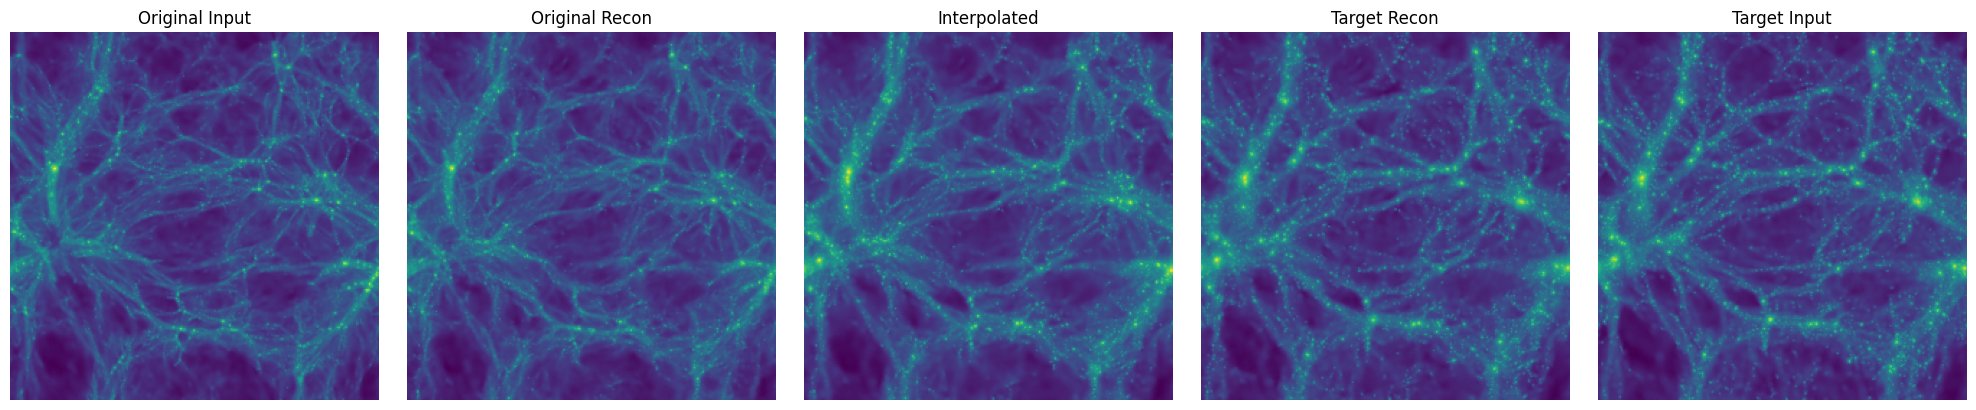

In [24]:
original_input    = img0
original_recon    = image_orig
interpolation     = image_interp
target_recon      = image_target
target_input      = img1

fig, axs = plt.subplots(1, 5, figsize=(20, 4))

fields = [
    original_input,
    original_recon,
    interpolation,
    target_recon,
    target_input,
]
titles = [
    "Original Input",
    "Original Recon",
    "Interpolated",
    "Target Recon",
    "Target Input",
]

for ax, field, title in zip(axs, fields, titles):
    ax.imshow(field, cmap="viridis", origin="lower")
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()
